In [77]:
import json
import os
import unicodedata
from functools import partial

In [120]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MultiLabelBinarizer

In [79]:
plt.rcParams.update({
    'text.usetex': True,
    'font.family': 'sans-serif'
})

In [80]:
credits = pd.read_csv(os.path.join('data', 'tmdb_5000_credits.csv'), index_col='movie_id')
movies = pd.read_csv(os.path.join('data', 'tmdb_5000_movies.csv'), index_col='id')

credits = credits.drop(columns=['title'])
movies = movies.join(credits)

del credits

## Feature processing

In [81]:
movies.columns

Index(['budget', 'genres', 'homepage', 'keywords', 'original_language',
       'original_title', 'overview', 'popularity', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'vote_average',
       'vote_count', 'cast', 'crew'],
      dtype='object')

In [82]:
movies.drop(columns=[
    'budget',
    'homepage',
    'original_title',
    'revenue',
    'status',
    'tagline',
    'vote_count',
    'crew'
], inplace=True)

### `genres`

In [83]:
movies.loc[19995, 'genres']

'[{"id": 28, "name": "Action"}, {"id": 12, "name": "Adventure"}, {"id": 14, "name": "Fantasy"}, {"id": 878, "name": "Science Fiction"}]'

In [84]:
def extract_genre_names(json_str):
    genres = map(lambda genre: genre['name'], json.loads(json_str))
    genres = map(lambda genre: genre.lower().replace(' ', '-'), genres)
    return set(genres)

In [85]:
movies['genres'] = movies['genres'].apply(extract_genre_names)

In [86]:
encoder_genres = MultiLabelBinarizer()
genres_enc = encoder_genres.fit_transform(movies['genres'])

genre_columns = list(map(lambda genre: f'is_{genre}', encoder_genres.classes_))
genres_enc = pd.DataFrame(genres_enc, columns=genre_columns, index=movies.index)

movies = movies.join(genres_enc)
movies = movies.drop(columns=['genres'])

In [87]:
movies.loc[19995, ['title'] + genre_columns]

title                 Avatar
is_action                  1
is_adventure               1
is_animation               0
is_comedy                  0
is_crime                   0
is_documentary             0
is_drama                   0
is_family                  0
is_fantasy                 1
is_foreign                 0
is_history                 0
is_horror                  0
is_music                   0
is_mystery                 0
is_romance                 0
is_science-fiction         1
is_thriller                0
is_tv-movie                0
is_war                     0
is_western                 0
Name: 19995, dtype: object

In [88]:
movies.loc[857, ['title'] + genre_columns]

title                 Saving Private Ryan
is_action                               0
is_adventure                            0
is_animation                            0
is_comedy                               0
is_crime                                0
is_documentary                          0
is_drama                                1
is_family                               0
is_fantasy                              0
is_foreign                              0
is_history                              1
is_horror                               0
is_music                                0
is_mystery                              0
is_romance                              0
is_science-fiction                      0
is_thriller                             0
is_tv-movie                             0
is_war                                  1
is_western                              0
Name: 857, dtype: object

In [89]:
(movies['overview'] + movies['keywords'])

id
19995     In the 22nd century, a paraplegic Marine is di...
285       Captain Barbossa, long believed to be dead, ha...
206647    A cryptic message from Bond’s past sends him o...
49026     Following the death of District Attorney Harve...
49529     John Carter is a war-weary, former military ca...
                                ...                        
9367      El Mariachi just wants to play his guitar and ...
72766     A newlywed couple's honeymoon is upended by th...
231617    "Signed, Sealed, Delivered" introduces a dedic...
126186    When ambitious New York attorney Sam is sent t...
25975     Ever since the second grade when he first saw ...
Length: 4803, dtype: object

### `overview` and `keywords`

In [90]:
movies['overview']

id
19995     In the 22nd century, a paraplegic Marine is di...
285       Captain Barbossa, long believed to be dead, ha...
206647    A cryptic message from Bond’s past sends him o...
49026     Following the death of District Attorney Harve...
49529     John Carter is a war-weary, former military ca...
                                ...                        
9367      El Mariachi just wants to play his guitar and ...
72766     A newlywed couple's honeymoon is upended by th...
231617    "Signed, Sealed, Delivered" introduces a dedic...
126186    When ambitious New York attorney Sam is sent t...
25975     Ever since the second grade when he first saw ...
Name: overview, Length: 4803, dtype: object

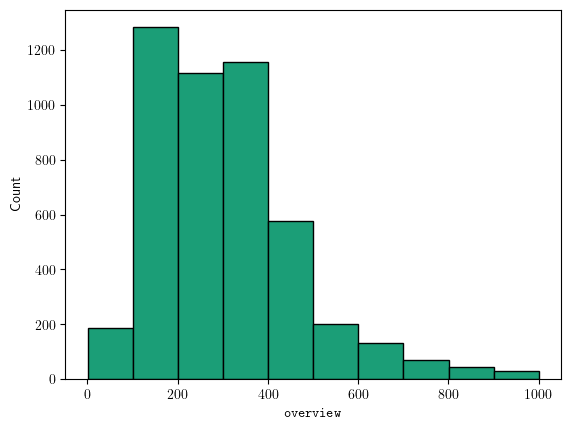

In [91]:
plt.hist(movies['overview'].str.len(), color='#1b9e77', edgecolor='k')
plt.xlabel(r'\texttt{overview}')
plt.ylabel(r'Count');

In [92]:
movies['overview'].isna().sum()

3

In [93]:
movies['overview'].fillna('', inplace=True)

In [94]:
def tokenize(raw_str):
    try:
        tokens = word_tokenize(raw_str)
    except LookupError:
        import nltk
        nltk.download('punkt')
    tokens = filter(lambda token: token.isalpha(), tokens)
    tokens = map(lambda token: token.lower(), tokens)
    tokens = map(partial(unicodedata.normalize, 'NFKC'), tokens)
    return list(tokens)

In [95]:
def to_wordnet_pos(penn_pos):
    if penn_pos.startswith('V'):
        return wordnet.VERB
    elif penn_pos.startswith('J'):
        return wordnet.ADJ
    elif penn_pos.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [96]:
def lemmatize(tokens):
    lemmatizer = WordNetLemmatizer()

    try:
        poss = list(map(lambda tag: to_wordnet_pos(tag[1]), pos_tag(tokens)))
    except LookupError:
        import nltk
        nltk.download('averaged_perceptron_tagger')

    tokens = [
        lemmatizer.lemmatize(token, pos=poss[i])
        for i, token in enumerate(tokens)
    ]

    return tokens

In [97]:
lemmatize(['was', 'were', 'being'])

['be', 'be', 'be']

In [98]:
lemmatize(['did', 'does', 'done'])

['do', 'do', 'do']

In [99]:
def normalize(raw_str):
    tokens = tokenize(raw_str)
    tokens = lemmatize(tokens)
    return tokens

In [100]:
movies.loc[19995, 'overview']

'In the 22nd century, a paraplegic Marine is dispatched to the moon Pandora on a unique mission, but becomes torn between following orders and protecting an alien civilization.'

In [101]:
' '.join(normalize(movies.loc[19995, 'overview']))

'in the century a paraplegic marine be dispatch to the moon pandora on a unique mission but become torn between follow order and protect an alien civilization'

In [102]:
movies['overview'] = movies['overview'] + movies['keywords']
movies.drop(columns=['keywords'], inplace=True)

In [103]:
movies['overview'].apply(normalize)

id
19995     [in, the, century, a, paraplegic, marine, be, ...
285       [captain, barbossa, long, believe, to, be, dea...
206647    [a, cryptic, message, from, bond, s, past, sen...
49026     [follow, the, death, of, district, attorney, h...
49529     [john, carter, be, a, former, military, captai...
                                ...                        
9367      [el, mariachi, just, want, to, play, his, guit...
72766     [a, newlywed, couple, honeymoon, be, upend, by...
231617    [sign, seal, deliver, introduces, a, dedicated...
126186    [when, ambitious, new, york, attorney, sam, be...
25975     [ever, since, the, second, grade, when, he, fi...
Name: overview, Length: 4803, dtype: object

In [104]:
try:
    stopwords.words('english')
except LookupError:
    import nltk
    nltk.download('stopwords')
stopwords_list = ENGLISH_STOP_WORDS.union(stopwords.words('english'))

In [106]:
encoder_overview = TfidfVectorizer(
    strip_accents=False,
    lowercase=False,
    preprocessor=None,
    tokenizer=None,
    analyzer=normalize,
    stop_words=stopwords_list,
    norm='l2',
    max_features=None
)
overview_enc = encoder_overview.fit_transform(movies['overview'])

overview_columns = list(map(lambda token: f'tfidf_{token}', encoder_overview.get_feature_names_out()))
overview_enc = pd.DataFrame(overview_enc.todense(), columns=overview_columns, index=movies.index)

movies = movies.join(overview_enc)
movies = movies.drop(columns=['overview'])

In [107]:
movies.columns[:20]

Index(['original_language', 'popularity', 'production_companies',
       'production_countries', 'release_date', 'runtime', 'spoken_languages',
       'title', 'vote_average', 'vote_count', 'cast', 'is_action',
       'is_adventure', 'is_animation', 'is_comedy', 'is_crime',
       'is_documentary', 'is_drama', 'is_family', 'is_fantasy'],
      dtype='object')

### `popularity` and `vote_average`

In [ ]:
movies['popularity'].describe()

Not sure if we should include this? Just because two movies have a similar
popularity doesn't mean they might be similar in content. (However, a movie with
a high `popularity` or `vote_average` might be a good recommendation *by pure
chance*, in the sense that it an average user is likelier to enjoy it.)

In [108]:
movies.drop(columns=['popularity', 'vote_average'], inplace=True)

### Potentially useful features with cardinality issues

* `production_companies` / `production_countries`
* `original_language` / `spoken_languages`
* `cast`
* `runtime`: English vs Hindi (weak determinant?)
* `release_date`: Variance within an era vs across eras (very weak determinant?)

In [109]:
movies.drop(columns=[
    'production_companies',
    'production_countries',
    'original_language',
    'spoken_languages',
    'cast',
    'runtime',
    'release_date'
], inplace=True)

In [111]:
movies.columns

Index(['title', 'vote_count', 'is_action', 'is_adventure', 'is_animation',
       'is_comedy', 'is_crime', 'is_documentary', 'is_drama', 'is_family',
       ...
       'tfidf_zuckerberg', 'tfidf_zula', 'tfidf_zurich', 'tfidf_zuzu',
       'tfidf_zyklon', 'tfidf_à', 'tfidf_æon', 'tfidf_éloigne', 'tfidf_émigré',
       'tfidf_única'],
      dtype='object', length=18860)

## Similarity

In [117]:
titles = movies['title']
movies.drop(columns=['title'], inplace=True)

In [118]:
movies

,is_action,is_adventure,is_animation,is_comedy,is_crime,is_documentary,is_drama,is_family,is_fantasy,is_foreign,...,tfidf_zuckerberg,tfidf_zula,tfidf_zurich,tfidf_zuzu,tfidf_zyklon,tfidf_à,tfidf_æon,tfidf_éloigne,tfidf_émigré,tfidf_única
id,,,,,,,,,,,,,,,,,,,,,
19995,1,1,0,0,0,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
285,1,1,0,0,0,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
206647,1,1,0,0,1,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
49026,1,0,0,0,1,0,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
49529,1,1,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9367,1,0,0,0,1,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
72766,0,0,0,1,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
231617,0,0,0,1,0,0,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [135]:
similarity = cosine_similarity(movies)
similarity = pd.DataFrame(similarity, index=movies.index, columns=movies.index)

In [149]:
def topn_similar(similarity, id, n=10):
    return list(similarity[id].sort_values(ascending=False).index[1:(n+1)])

In [154]:
def pprint_topn_similar(similarity, id, titles, n=10):
    print(f'Top {n} similar movies to \"{titles[id]}\":')
    for similar_id in topn_similar(similarity, id, n=n):
        print(f'* {titles[similar_id]}')

In [156]:
pprint_topn_similar(similarity, 425, titles, n=10)

Top 10 similar movies to "Ice Age":
* Ice Age: The Meltdown
* Ice Age: Dawn of the Dinosaurs
* Ice Age: Continental Drift
* Kung Fu Panda
* TMNT
* Cars
* Curious George
* Antz
* Up
* Bolt


In [157]:
pprint_topn_similar(similarity, 862, titles, n=10)

Top 10 similar movies to "Toy Story":
* Toy Story 3
* Toy Story 2
* Hotel Transylvania 2
* Monsters, Inc.
* The Simpsons Movie
* Despicable Me 2
* Over the Hedge
* Free Birds
* Doug's 1st Movie
* Chicken Little


In [162]:
pprint_topn_similar(similarity, 411, titles, n=10)

Top 10 similar movies to "The Chronicles of Narnia: The Lion, the Witch and the Wardrobe":
* The Chronicles of Narnia: Prince Caspian
* The Wizard of Oz
* The Chronicles of Narnia: The Voyage of the Dawn Treader
* Harry Potter and the Chamber of Secrets
* Harry Potter and the Philosopher's Stone
* Oz: The Great and Powerful
* The Spiderwick Chronicles
* Harry Potter and the Half-Blood Prince
* The Indian in the Cupboard
* Harry Potter and the Prisoner of Azkaban


In [155]:
pprint_topn_similar(similarity, 857, titles, n=10)

Top 10 similar movies to "Saving Private Ryan":
* The Thin Red Line
* The Wind That Shakes the Barley
* Downfall
* Schindler's List
* Gettysburg
* Patton
* City of Life and Death
* Hotel Rwanda
* Gods and Generals
* Amigo


In [161]:
titles.to_csv('temp.csv')